# Word2Vec+TextCNN

导入包

In [2]:
import random

import numpy as np
import torch
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)-15s %(levelname)s: %(message)s', filename='output.log')

# set seed 
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)

# set cuda
gpu = 0
use_cuda = gpu >= 0 and torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(gpu)
    device = torch.device("cuda", gpu)
else:
    device = torch.device("cpu")
logging.info("Use cuda: %s, gpu id: %d.", use_cuda, gpu)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## 数据处理

数据首先会经过all_data2fold函数，这个函数的作用是把原始的 DataFrame 数据，转换为一个list，有 10 个元素，表示交叉验证里的 10 份，每个元素是 dict，每个dict包括 label 和 text。

首先根据 label 来划分数据行所在 index, 生成 label2id。label2id 是一个 dict，key 为 label，value 是一个 list，存储的是该类对应的 index。

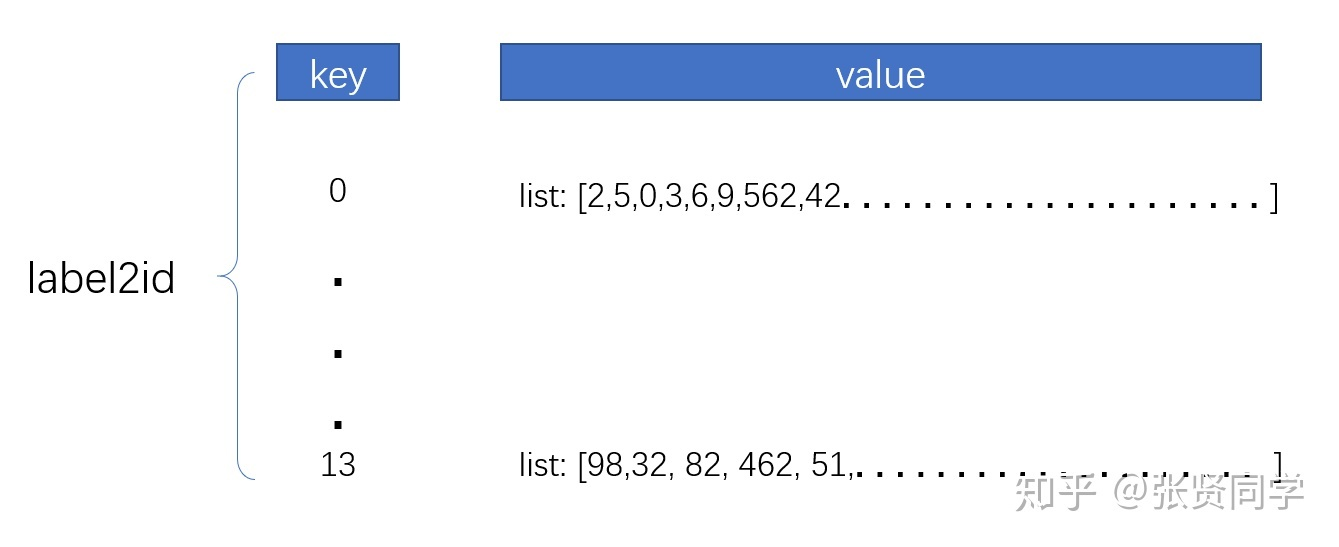

然后根据label2id，把每一类别的数据，划分到 10 份数据中。

最终得到的数据fold_data是一个list，有 10 个元素，每个元素是 dict，包括 label 和 text的列表：[{labels:textx}, {labels:textx}. . .]。

### 把数据分成  10 份

In [1]:
# split data to 10 fold
fold_num = 10
data_file = './data/train_set.csv'
import pandas as pd


def all_data2fold(fold_num):
    fold_data = []
    f = pd.read_csv(data_file, sep='\t', encoding='UTF-8')
    texts = f['text'].tolist()[:]
    labels = f['label'].tolist()[:]
    

    
    total = len(labels)  # 数据总数

    index = list(range(total))
    # 打乱数据
    np.random.shuffle(index)

    # all_texts 和 all_labels 都是 shuffle 之后的数据
    all_texts = []
    all_labels = []
    for i in index:
        all_texts.append(texts[i])
        all_labels.append(labels[i])

    # 构造一个 dict，key 为 label，value 是一个 list，存储的是该类对应的 index
    label2id = {}
    for i in range(total):
        label = str(all_labels[i])
        if label not in label2id:
            label2id[label] = [i]
        else:
            label2id[label].append(i)

    # all_index 是一个 list，里面包括 10 个 list，称为 10 个 fold，存储 10 个 fold 对应的 index
    all_index = [[] for _ in range(fold_num)]
    for label, data in label2id.items():
        # print(label, len(data))
        batch_size = int(len(data) / fold_num)
        # other 表示多出来的数据，other 的数据量是小于 fold_num 的
        other = len(data) - batch_size * fold_num
        # 把每一类对应的 index，添加到每个 fold 里面去
        for i in range(fold_num):
            # 如果 i < other，那么将一个数据添加到这一轮 batch 的数据中
            cur_batch_size = batch_size + 1 if i < other else batch_size
            # print(cur_batch_size)
            # batch_data 是该轮 batch 对应的索引
            batch_data = [data[i * batch_size + b] for b in range(cur_batch_size)]
            all_index[i].extend(batch_data)

    batch_size = int(total / fold_num)
    other_texts = []
    other_labels = []
    other_num = 0
    start = 0
    
    # 由于上面在分 batch 的过程中，每个 batch 的数据量不一样，这里是把数据平均到每个 batch
    for fold in range(fold_num):
        num = len(all_index[fold])
        texts = [all_texts[i] for i in all_index[fold]]
        labels = [all_labels[i] for i in all_index[fold]]

        if num > batch_size: # 如果大于 batch_size 那么就取 batch_size 大小的数据
            fold_texts = texts[:batch_size]
            other_texts.extend(texts[batch_size:])
            fold_labels = labels[:batch_size]
            other_labels.extend(labels[batch_size:])
            other_num += num - batch_size
        elif num < batch_size: # 如果小于 batch_size，那么就补全到 batch_size 的大小
            end = start + batch_size - num
            fold_texts = texts + other_texts[start: end]
            fold_labels = labels + other_labels[start: end]
            start = end
        else:
            fold_texts = texts
            fold_labels = labels

        assert batch_size == len(fold_labels)

        # shuffle
        index = list(range(batch_size))
        np.random.shuffle(index)
        # 这里是为了打乱数据
        shuffle_fold_texts = []
        shuffle_fold_labels = []
        for i in index:
            shuffle_fold_texts.append(fold_texts[i])
            shuffle_fold_labels.append(fold_labels[i])

        data = {'label': shuffle_fold_labels, 'text': shuffle_fold_texts}
        fold_data.append(data)

    logging.info("Fold lens %s", str([len(data['label']) for data in fold_data]))

    return fold_data

# fold_data 是一个 list，有 10 个元素，每个元素是 dict，包括 label 和 text
fold_data = all_data2fold(10)

NameError: name 'np' is not defined

### 拆分训练集、验证集，读取测试集

In [ ]:
# build train, dev, test data
fold_id = 9

# 验证集
dev_data = fold_data[fold_id]

# train 取出前 9 个 fold 的数据
train_texts = []
train_labels = []
for i in range(0, fold_id):
    data = fold_data[i]
    train_texts.extend(data['text'])
    train_labels.extend(data['label'])

train_data = {'label': train_labels, 'text': train_texts}

# test 读取测试集数据
test_data_file = './data/test_a.csv'
f = pd.read_csv(test_data_file, sep='\t', encoding='UTF-8')
texts = f['text'].tolist()
test_data = {'label': [0] * len(texts), 'text': texts}

# 创建 Vocab

Vocab 的作用是：

1.创建 词 和 index 对应的字典，这里包括 2 份字典，分别是：_id2word 和 _id2extword。

    其中 _id2word 是从新闻得到的， 把词频小于 5 的词替换为了 UNK。对应到模型输入的 batch_inputs1。

    _id2extword 是从 word2vec.txt 中得到的，有 5976 个词。对应到模型输入的 batch_inputs2。

    后面会有两个 embedding 层，其中 _id2word 对应的 embedding 是可学习的，_id2extword 对应的 embedding 是从文件中加载的，是固定的。

2.创建 label 和 index 对应的字典。

    上面这些字典，都是基于train_data创建的。

**NLP中＜SOS＞、＜EOS＞、＜UNK＞、＜PAD＞等标识符的含义**

    SOS、BOS、GO：代表一个序列的开始。

    EOS：代表一个序列的结束，作为判断终止的标签。

    MASK：用于遮盖句子中的一些单词。

    UNK：未知字符，代表词典中没有的词。

    SEP: 用于分隔两个输入句子，例如输入句子 A 和 B，要在句子 A，B 后面增加 <SEP> 标志。

    CLS ：放在句子的首位，表示句子的开始，就是classification的意思，通常会在bert等模型出现。

    PAD：补全字符，例如要将句子处理为特定的长度，我们就要在句子前后补<PAD>。


In [16]:
# build vocab
from collections import Counter
from transformers import BasicTokenizer

basic_tokenizer = BasicTokenizer()
'''
Vocab 的作用是：
1. 创建 词 和 index 对应的字典，这里包括 2 份字典，分别是：_id2word 和 _id2extword
其中 _id2word 是从新闻得到的， 把词频小于 5 的词替换为了 UNK。对应到模型输入的 batch_inputs1。
_id2extword 是从 word2vec.txt 中得到的，有 5976 个词。对应到模型输入的 batch_inputs2。
后面会有两个 embedding 层，其中 _id2word 对应的 embedding 是可学习的，_id2extword 对应的 embedding 是从文件中加载的，是固定的
2.创建 label 和 index 对应的字典
'''

class Vocab():
    def __init__(self, train_data):
        self.min_count = 5
        self.pad = 0
        self.unk = 1
        self._id2word = ['[PAD]', '[UNK]']
        self._id2extword = ['[PAD]', '[UNK]']

        self._id2label = []
        self.target_names = []

        self.build_vocab(train_data)

        reverse = lambda x: dict(zip(x, range(len(x))))
        #创建词和 index 对应的字典
        self._word2id = reverse(self._id2word)
        #创建 label 和 index 对应的字典
        self._label2id = reverse(self._id2label)

        logging.info("Build vocab: words %d, labels %d." % (self.word_size, self.label_size))

    #创建词典
    def build_vocab(self, data):
        self.word_counter = Counter()
        #计算每个词出现的次数
        for text in data['text']:
            words = text.split()
            for word in words:
                self.word_counter[word] += 1
        # 去掉频次小于 min_count = 5 的词，把词存到 _id2word
        for word, count in self.word_counter.most_common():
            if count >= self.min_count:
                self._id2word.append(word)

        label2name = {0: '科技', 1: '股票', 2: '体育', 3: '娱乐', 4: '时政', 5: '社会', 6: '教育', 7: '财经',
                      8: '家居', 9: '游戏', 10: '房产', 11: '时尚', 12: '彩票', 13: '星座'}

        self.label_counter = Counter(data['label'])

        for label in range(len(self.label_counter)):
            count = self.label_counter[label] # 取出 label 对应的次数
            self._id2label.append(label) 
            self.target_names.append(label2name[label]) # 根据label数字取出对应的名字

    def load_pretrained_embs(self, embfile):
        with open(embfile, encoding='utf-8') as f:
            lines = f.readlines()
            items = lines[0].split()
            # 第一行分别是单词数量、词向量维度
            word_count, embedding_dim = int(items[0]), int(items[1])

        index = len(self._id2extword)
        embeddings = np.zeros((word_count + index, embedding_dim))
        # 下面的代码和 word2vec.txt 的结构有关
        for line in lines[1:]:
            values = line.split()
            self._id2extword.append(values[0]) # 首先添加第一列的单词
            vector = np.array(values[1:], dtype='float64') # 然后添加后面 100 列的词向量
            embeddings[self.unk] += vector
            embeddings[index] = vector
            index += 1

        # unk 的词向量是所有词的平均
        embeddings[self.unk] = embeddings[self.unk] / word_count
        # 除以标准差干嘛？
        embeddings = embeddings / np.std(embeddings)

        reverse = lambda x: dict(zip(x, range(len(x))))
        self._extword2id = reverse(self._id2extword)

        assert len(set(self._id2extword)) == len(self._id2extword)

        return embeddings

    # 根据单词得到 id
    def word2id(self, xs):
        if isinstance(xs, list):
            return [self._word2id.get(x, self.unk) for x in xs]
        return self._word2id.get(xs, self.unk)
    # 根据单词得到 ext id
    def extword2id(self, xs):
        if isinstance(xs, list):
            return [self._extword2id.get(x, self.unk) for x in xs]
        return self._extword2id.get(xs, self.unk)
    # 根据 label 得到 id
    def label2id(self, xs):
        if isinstance(xs, list):
            return [self._label2id.get(x, self.unk) for x in xs]
        return self._label2id.get(xs, self.unk)

    @property
    def word_size(self):
        return len(self._id2word)

    @property
    def extword_size(self):
        return len(self._id2extword)

    @property
    def label_size(self):
        return len(self._id2label)


vocab = Vocab(train_data)

## 模型
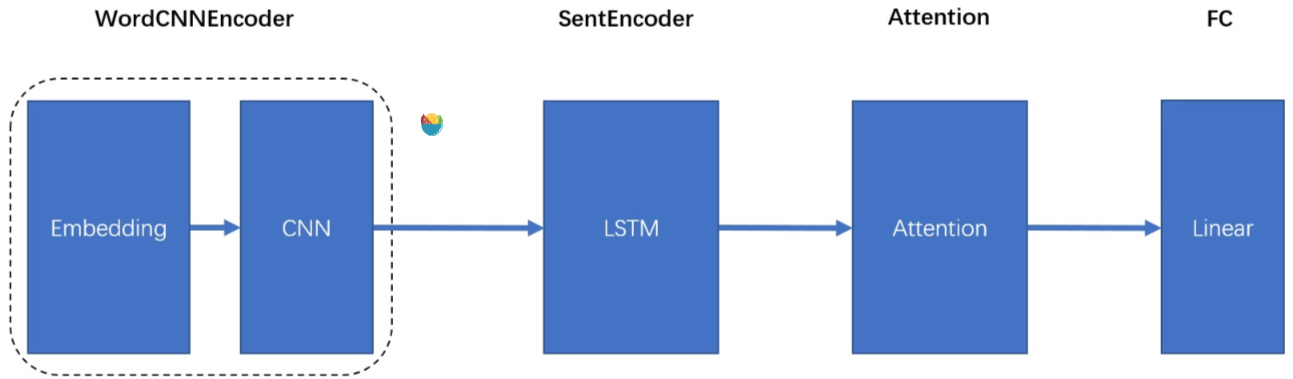

**Embedding**
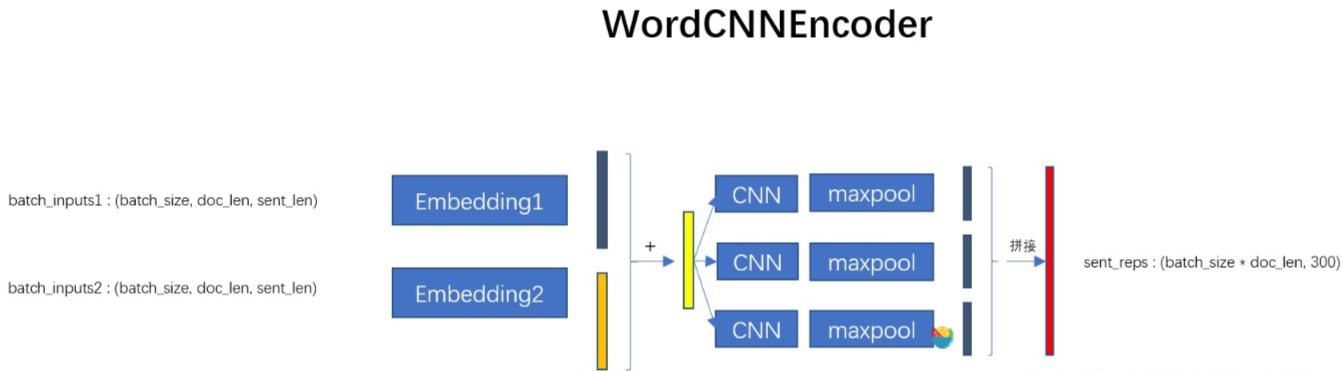
batch_inputs1, batch_inputs2都输入到WordCNNEncoder。WordCNNEncoder包括两个embedding层，分别对应batch_inputs1，embedding 层是可学习的，得到word_embed；batch_inputs2，读取的是外部训练好的词向量，因此是不可学习的，得到extword_embed。所以会分别得到两个词向量，将 2 个词向量相加，得到最终的词向量batch_embed，形状是(batch_size * doc_len, sent_len, 100)，然后添加一个维度，变为(batch_size * doc_len, 1, sent_len, 100)，对应 Pytorch 里图像的(B, C, H, W)。

**CNN**

然后，分别定义 3 个卷积核，output channel 都是 100 维。

第一个卷积核大小为[2,100]，得到的输出是(batch_size * doc_len, 100， sent_len-2+1, 1)，定义一个池化层大小为[sent_len-2+1, 1]，最终得到输出经过squeeze()的形状是(batch_size * doc_len, 100)。

同理，第 2 个卷积核大小为[3,100]，第 3 个卷积核大小为[4,100]。卷积+池化得到的输出形状也是(batch_size * doc_len, 100)。

最后，将这 3 个向量在第 2 个维度上做拼接，得到输出的形状是(batch_size * doc_len, 300)。

**shape 转换**

把上一步得到的数据的形状，转换为(batch_size , doc_len, 300)名字是sent_reps。然后，对mask进行处理。

batch_masks的形状是(batch_size , doc_len, 300)，表示单词的 mask，经过sent_masks = batch_masks.bool().any(2).float()得到句子的 mask。含义是：在最后一个维度，判断是否有单词，只要有 1 个单词，那么整句话的 mask 就是 1，sent_masks的维度是：(batch_size , doc_len)。

**SentEncoder**

SentEncoder 网络结构示意图如下：
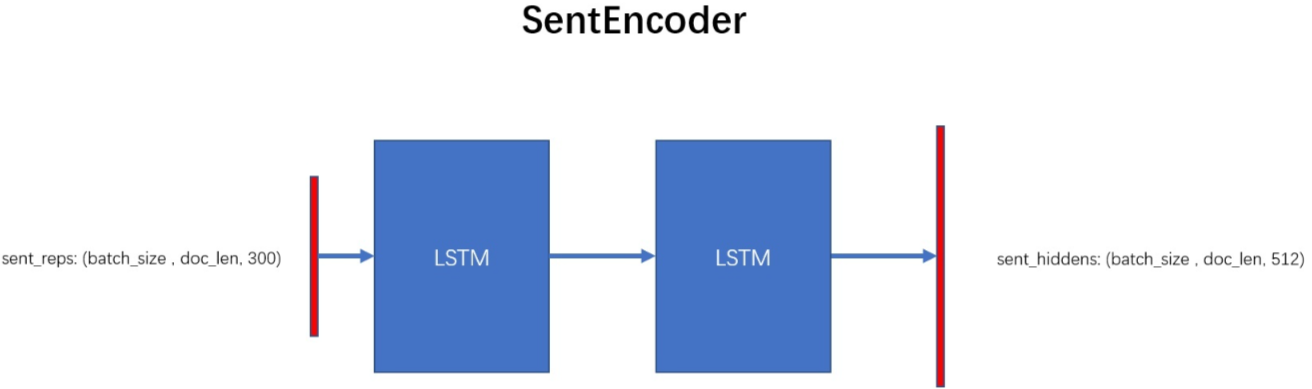
SentEncoder包含了 2 层的双向 LSTM，输入数据sent_reps的形状是(batch_size , doc_len, 300)，LSTM 的 hidden_size 为 256，由于是双向的，经过 LSTM 后的数据维度是(batch_size , doc_len, 512)，然后和 mask 按位置相乘，把没有单词的句子的位置改为 0，最后输出的数据sent_hiddens，维度依然是(batch_size , doc_len, 512)。

**Attention**

接着，经过Attention。Attention的输入是sent_hiddens和sent_masks。在Attention里，sent_hiddens首先经过线性变化得到key，维度不变，依然是(batch_size , doc_len, 512)。

然后key和query相乘，得到outputs。query的维度是512，因此output的维度是(batch_size , doc_len)，这个就是我们需要的attention，表示分配到每个句子的权重。下一步需要对这个attetion做softmax，并使用sent_masks，把没有单词的句子的权重置为-1e32，得到masked_attn_scores。

最后把masked_attn_scores和key相乘，得到batch_outputs，形状是(batch_size, 512)。

### 定义 Attention

In [17]:
# build module
import torch.nn as nn
import torch.nn.functional as F


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.weight.data.normal_(mean=0.0, std=0.05)

        self.bias = nn.Parameter(torch.Tensor(hidden_size))
        b = np.zeros(hidden_size, dtype=np.float32)
        self.bias.data.copy_(torch.from_numpy(b))

        self.query = nn.Parameter(torch.Tensor(hidden_size))
        self.query.data.normal_(mean=0.0, std=0.05)

    def forward(self, batch_hidden, batch_masks):
        # batch_hidden: b * doc_len * hidden_size (2 * hidden_size of lstm)
        # batch_masks:  b x doc_len

        # linear
        # key： b * doc_len * hidden
        key = torch.matmul(batch_hidden, self.weight) + self.bias 

        # compute attention
        # matmul 会进行广播
        #outputs: b * doc_len
        outputs = torch.matmul(key, self.query)  
        # 1 - batch_masks 就是取反，把没有单词的句子置为 0
        # masked_fill 的作用是 在 为 1 的地方替换为 value: float(-1e32)
        masked_outputs = outputs.masked_fill((1 - batch_masks).bool(), float(-1e32))
        #attn_scores：b * doc_len
        attn_scores = F.softmax(masked_outputs, dim=1)  

        # 对于全零向量，-1e32的结果为 1/len, -inf为nan, 额外补0
        masked_attn_scores = attn_scores.masked_fill((1 - batch_masks).bool(), 0.0)

        # sum weighted sources
        # masked_attn_scores.unsqueeze(1)：# b * 1 * doc_len
        # key：b * doc_len * hidden
        # batch_outputs：b * hidden
        batch_outputs = torch.bmm(masked_attn_scores.unsqueeze(1), key).squeeze(1)  

        return batch_outputs, attn_scores

### 定义 WordCNNEncoder

In [18]:
word2vec_path = 'word2vec.txt'
dropout = 0.15

In [19]:
# 输入是：
    # word_ids: sentence_num * sentence_len
    # extword_ids: sentence_num * sentence_len
# 输出是：sen_num * (3*out_channel)
class WordCNNEncoder(nn.Module):
    def __init__(self, vocab):
        super(WordCNNEncoder, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.word_dims = 100 # 词向量的长度是 100 维
        # padding_idx 表示当取第 0 个词时，向量全为 0
        # 这个 Embedding 层是可学习的
        self.word_embed = nn.Embedding(vocab.word_size, self.word_dims, padding_idx=0)

        extword_embed = vocab.load_pretrained_embs(word2vec_path)
        extword_size, word_dims = extword_embed.shape
        logging.info("Load extword embed: words %d, dims %d." % (extword_size, word_dims))

        # # 这个 Embedding 层是不可学习的
        self.extword_embed = nn.Embedding(extword_size, word_dims, padding_idx=0)
        self.extword_embed.weight.data.copy_(torch.from_numpy(extword_embed))
        self.extword_embed.weight.requires_grad = False

        input_size = self.word_dims

        self.filter_sizes = [2, 3, 4]  # n-gram window
        self.out_channel = 100
        # 3 个卷积层，卷积核大小分别为 [2,100], [3,100], [4,100]
        self.convs = nn.ModuleList([nn.Conv2d(1, self.out_channel, (filter_size, input_size), bias=True)
                                    for filter_size in self.filter_sizes])

    def forward(self, word_ids, extword_ids):
        # word_ids: sentence_num * sentence_len
        # extword_ids: sentence_num * sentence_len
        # batch_masks: sentence_num * sentence_len
        sen_num, sent_len = word_ids.shape
        
        # word_embed: sentence_num * sentence_len * 100
        # 根据 index 取出词向量
        word_embed = self.word_embed(word_ids)
        extword_embed = self.extword_embed(extword_ids)
        batch_embed = word_embed + extword_embed

        if self.training:
            batch_embed = self.dropout(batch_embed)
        # batch_embed: sentence_num x 1 x sentence_len x 100
        # squeeze 是为了添加一个 channel 的维度，成为 B * C * H * W
        # 方便下面做 卷积
        batch_embed.unsqueeze_(1)  

        pooled_outputs = []
        # 通过 3 个卷积核做 3 次卷积核池化
        for i in range(len(self.filter_sizes)):
            # 通过池化公式计算池化后的高度: o = (i-k)/s+1
            # 其中 o 表示输出的长度
            # k 表示卷积核大小
            # s 表示步长，这里为 1
            filter_height = sent_len - self.filter_sizes[i] + 1
            # conv：sentence_num * out_channel * filter_height * 1
            conv = self.convs[i](batch_embed)
            hidden = F.relu(conv)  
            # 定义池化层
            mp = nn.MaxPool2d((filter_height, 1))  # (filter_height, filter_width)
            # pooled：sentence_num * out_channel * 1 * 1 -> sen_num * out_channel
            # 也可以通过 squeeze 来删除无用的维度
            pooled = mp(hidden).reshape(sen_num,
                                        self.out_channel) 
            
            pooled_outputs.append(pooled)
        # 拼接 3 个池化后的向量
        # reps: sen_num * (3*out_channel)
        reps = torch.cat(pooled_outputs, dim=1)  

        if self.training:
            reps = self.dropout(reps)

        return reps

### 定义 SentEncoder

In [20]:
# build sent encoder
sent_hidden_size = 256
sent_num_layers = 2


class SentEncoder(nn.Module):
    def __init__(self, sent_rep_size):
        super(SentEncoder, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.sent_lstm = nn.LSTM(
            input_size=sent_rep_size, # 每个句子经过 CNN 后得到 300 维向量
            hidden_size=sent_hidden_size,# 输出的维度
            num_layers=sent_num_layers,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, sent_reps, sent_masks):
        # sent_reps:  b * doc_len * sent_rep_size
        # sent_masks: b * doc_len
        # sent_hiddens:  b * doc_len * hidden*2
        # sent_hiddens:  batch, seq_len, num_directions * hidden_size
        sent_hiddens, _ = self.sent_lstm(sent_reps)  
        # 对应相乘，用到广播，是为了只保留有句子的位置的数值
        sent_hiddens = sent_hiddens * sent_masks.unsqueeze(2)
        
        if self.training:
            sent_hiddens = self.dropout(sent_hiddens)

        return sent_hiddens

### 定义整个模型Attention
把 WordCNNEncoder、SentEncoder、Attention、FC 全部连接起来

In [21]:
# build model
class Model(nn.Module):
    def __init__(self, vocab):
        super(Model, self).__init__()
        self.sent_rep_size = 300 # 经过 CNN 后得到的 300 维向量
        self.doc_rep_size = sent_hidden_size * 2 # lstm 最后输出的向量长度
        self.all_parameters = {}
        parameters = []
        self.word_encoder = WordCNNEncoder(vocab)
        
        parameters.extend(list(filter(lambda p: p.requires_grad, self.word_encoder.parameters())))

        self.sent_encoder = SentEncoder(self.sent_rep_size)
        self.sent_attention = Attention(self.doc_rep_size)
        parameters.extend(list(filter(lambda p: p.requires_grad, self.sent_encoder.parameters())))
        parameters.extend(list(filter(lambda p: p.requires_grad, self.sent_attention.parameters())))
        # doc_rep_size
        self.out = nn.Linear(self.doc_rep_size, vocab.label_size, bias=True)
        parameters.extend(list(filter(lambda p: p.requires_grad, self.out.parameters())))

        if use_cuda:
            self.to(device)

        if len(parameters) > 0:
            self.all_parameters["basic_parameters"] = parameters

        logging.info('Build model with cnn word encoder, lstm sent encoder.')

        para_num = sum([np.prod(list(p.size())) for p in self.parameters()])
        logging.info('Model param num: %.2f M.' % (para_num / 1e6))
    def forward(self, batch_inputs):
        # batch_inputs(batch_inputs1, batch_inputs2): b * doc_len * sentence_len
        # batch_masks : b * doc_len * sentence_len
        batch_inputs1, batch_inputs2, batch_masks = batch_inputs
        batch_size, max_doc_len, max_sent_len = batch_inputs1.shape[0], batch_inputs1.shape[1], batch_inputs1.shape[2]
        # batch_inputs1: sentence_num * sentence_len
        batch_inputs1 = batch_inputs1.view(batch_size * max_doc_len, max_sent_len)  
        # batch_inputs2: sentence_num * sentence_len
        batch_inputs2 = batch_inputs2.view(batch_size * max_doc_len, max_sent_len)
        # batch_masks: sentence_num * sentence_len 
        batch_masks = batch_masks.view(batch_size * max_doc_len, max_sent_len)  
        # sent_reps: sentence_num * sentence_rep_size
        # sen_num * (3*out_channel) =  sen_num * 300
        sent_reps = self.word_encoder(batch_inputs1, batch_inputs2) 
        
        
        # sent_reps：b * doc_len * sent_rep_size
        sent_reps = sent_reps.view(batch_size, max_doc_len, self.sent_rep_size)  
        # batch_masks：b * doc_len * max_sent_len
        batch_masks = batch_masks.view(batch_size, max_doc_len, max_sent_len)  
        # sent_masks：b * doc_len any(2) 表示在 第二个维度上判断
        # 表示如果如果一个句子中有词 true，那么这个句子就是 true，用于给 lstm 过滤
        sent_masks = batch_masks.bool().any(2).float()  # b x doc_len
        # sent_hiddens: b * doc_len * num_directions * hidden_size
        # sent_hiddens:  batch, seq_len, 2 * hidden_size
        sent_hiddens = self.sent_encoder(sent_reps, sent_masks)  
        
        
        # doc_reps: b * (2 * hidden_size)
        # atten_scores: b * doc_len
        doc_reps, atten_scores = self.sent_attention(sent_hiddens, sent_masks)  
        
        # b * num_labels
        batch_outputs = self.out(doc_reps)  

        return batch_outputs


model = Model(vocab)

### 定义 Optimizer

In [22]:
# build optimizer
learning_rate = 2e-4
decay = .75
decay_step = 1000


class Optimizer:
    def __init__(self, model_parameters):
        self.all_params = []
        self.optims = []
        self.schedulers = []

        for name, parameters in model_parameters.items():
            if name.startswith("basic"):
                optim = torch.optim.Adam(parameters, lr=learning_rate)
                self.optims.append(optim)

                l = lambda step: decay ** (step // decay_step)
                scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=l)
                self.schedulers.append(scheduler)
                self.all_params.extend(parameters)

            else:
                Exception("no nameed parameters.")

        self.num = len(self.optims)

    def step(self):
        for optim, scheduler in zip(self.optims, self.schedulers):
            optim.step()
            scheduler.step()
            optim.zero_grad()

    def zero_grad(self):
        for optim in self.optims:
            optim.zero_grad()

    def get_lr(self):
        lrs = tuple(map(lambda x: x.get_lr()[-1], self.schedulers))
        lr = ' %.5f' * self.num
        res = lr % lrs
        return res

### 定义 sentence_split，把文章划分为句子

In [23]:
# 
# 作用是：根据一篇文章，把这篇文章分割成多个句子
# text 是一个新闻的文章
# vocab 是词典
# max_sent_len 表示每句话的长度
# max_segment 表示最多有几句话
# 最后返回的 segments 是一个list，其中每个元素是 tuple：(句子长度，句子本身)
def sentence_split(text, vocab, max_sent_len=256, max_segment=16):
    
    words = text.strip().split()
    document_len = len(words)
    # 划分句子的索引，句子长度为 max_sent_len
    index = list(range(0, document_len, max_sent_len))
    index.append(document_len)

    segments = []
    for i in range(len(index) - 1):
        # 根据索引划分句子
        segment = words[index[i]: index[i + 1]]
        assert len(segment) > 0
        # 把出现太少的词替换为 UNK
        segment = [word if word in vocab._id2word else '<UNK>' for word in segment]
        # 添加 tuple:(句子长度，句子本身)
        segments.append([len(segment), segment])

    assert len(segments) > 0
    # 如果大于 max_segment 句话，则局数减少一半，返回一半的句子
    if len(segments) > max_segment:
        segment_ = int(max_segment / 2)
        return segments[:segment_] + segments[-segment_:]
    else:
        # 否则返回全部句子
        return segments

### 定义 get_examples
里面调用 sentence_split

In [24]:
# 最后返回的数据是一个 list，每个元素是一个 tuple: (label, 句子数量，doc)
# 其中 doc 又是一个 list，每个 元素是一个 tuple: (句子长度，word_ids, extword_ids)
def get_examples(data, vocab, max_sent_len=256, max_segment=8):
    label2id = vocab.label2id
    examples = []

    for text, label in zip(data['text'], data['label']):
        # label
        id = label2id(label)

        # sents_words: 是一个list，其中每个元素是 tuple：(句子长度，句子本身)
        sents_words = sentence_split(text, vocab, max_sent_len, max_segment)
        doc = []
        for sent_len, sent_words in sents_words:
            # 把 word 转为 id
            word_ids = vocab.word2id(sent_words)
            # 把 word 转为 ext id
            extword_ids = vocab.extword2id(sent_words)
            doc.append([sent_len, word_ids, extword_ids])
        examples.append([id, len(doc), doc])

    logging.info('Total %d docs.' % len(examples))
    return examples

### 定义 batch_slice

In [25]:
# build loader
# data 参数就是 get_examples() 得到的
# data是一个 list，每个元素是一个 tuple: (label, 句子数量，doc)
# 其中 doc 又是一个 list，每个 元素是一个 tuple: (句子长度，word_ids, extword_ids)
def batch_slice(data, batch_size):
    batch_num = int(np.ceil(len(data) / float(batch_size)))
    for i in range(batch_num):
        # 如果 i < batch_num - 1，那么大小为 batch_size，否则就是最后一批数据
        cur_batch_size = batch_size if i < batch_num - 1 else len(data) - batch_size * i
        docs = [data[i * batch_size + b] for b in range(cur_batch_size)]

        yield docs


### 定义 data_iter
里面调用 batch_slice

In [26]:
# data 参数就是 get_examples() 得到的
# data是一个 list，每个元素是一个 tuple: (label, 句子数量，doc)
# 其中 doc 又是一个 list，每个 元素是一个 tuple: (句子长度，word_ids, extword_ids)
def data_iter(data, batch_size, shuffle=True, noise=1.0):
    """
    randomly permute data, then sort by source length, and partition into batches
    ensure that the length of  sentences in each batch
    """

    batched_data = []
    if shuffle:
        # 这里是打乱所有数据
        np.random.shuffle(data)
        # lengths 表示的是 每篇文章的句子数量
        lengths = [example[1] for example in data] 
        noisy_lengths = [- (l + np.random.uniform(- noise, noise)) for l in lengths]
        sorted_indices = np.argsort(noisy_lengths).tolist()
        sorted_data = [data[i] for i in sorted_indices]
    else:
        sorted_data = data
    # 把 batch 的数据放进一个 list    
    batched_data.extend(list(batch_slice(sorted_data, batch_size)))

    if shuffle:
        # 打乱 多个 batch
        np.random.shuffle(batched_data)

    for batch in batched_data:
        yield batch

### 定义指标计算

In [27]:
# some function
from sklearn.metrics import f1_score, precision_score, recall_score


def get_score(y_ture, y_pred):
    y_ture = np.array(y_ture)
    y_pred = np.array(y_pred)
    f1 = f1_score(y_ture, y_pred, average='macro') * 100
    p = precision_score(y_ture, y_pred, average='macro') * 100
    r = recall_score(y_ture, y_pred, average='macro') * 100

    return str((reformat(p, 2), reformat(r, 2), reformat(f1, 2))), reformat(f1, 2)

# 保留 n 位小数点
def reformat(num, n):
    return float(format(num, '0.' + str(n) + 'f'))

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### 定义训练和测试的方法
包括 batch2tensor

In [28]:
# build trainer

import time
from sklearn.metrics import classification_report

clip = 5.0
epochs = 17
early_stops = 3
log_interval = 50

test_batch_size = 128
train_batch_size = 128

save_model = './cnn0.bin'
save_test = './cnn0.csv'

class Trainer():
    def __init__(self, model, vocab):
        self.model = model
        self.report = True

        # get_examples() 返回的结果是 一个 list
        # 每个元素是一个 tuple: (label, 句子数量，doc)
        # 其中 doc 又是一个 list，每个 元素是一个 tuple: (句子长度，word_ids, extword_ids)
        self.train_data = get_examples(train_data, vocab)
        self.batch_num = int(np.ceil(len(self.train_data) / float(train_batch_size)))
        self.dev_data = get_examples(dev_data, vocab)
        self.test_data = get_examples(test_data, vocab)

        # criterion
        self.criterion = nn.CrossEntropyLoss()

        # label name
        self.target_names = vocab.target_names

        # optimizer
        self.optimizer = Optimizer(model.all_parameters)

        # count
        self.step = 0
        self.early_stop = -1
        self.best_train_f1, self.best_dev_f1 = 0, 0
        self.last_epoch = epochs

    def train(self):
        logging.info('Start training...')
        for epoch in range(1, epochs + 1):
            train_f1 = self._train(epoch)

            dev_f1 = self._eval(epoch)

            if self.best_dev_f1 <= dev_f1:
                logging.info(
                    "Exceed history dev = %.2f, current dev = %.2f" % (self.best_dev_f1, dev_f1))
                torch.save(self.model.state_dict(), save_model)

                self.best_train_f1 = train_f1
                self.best_dev_f1 = dev_f1
                self.early_stop = 0
            else:
                self.early_stop += 1
                if self.early_stop == early_stops:
                    logging.info(
                        "Eearly stop in epoch %d, best train: %.2f, dev: %.2f" % (
                            epoch - early_stops, self.best_train_f1, self.best_dev_f1))
                    self.last_epoch = epoch
                    break

    def test(self):
        self.model.load_state_dict(torch.load(save_model))
        self._eval(self.last_epoch + 1, test=True)
    
    def _train(self, epoch):
        self.optimizer.zero_grad()
        self.model.train()

        start_time = time.time()
        epoch_start_time = time.time()
        overall_losses = 0
        losses = 0
        batch_idx = 1
        y_pred = []
        y_true = []
        for batch_data in data_iter(self.train_data, train_batch_size, shuffle=True):
            torch.cuda.empty_cache()
            # batch_inputs: (batch_inputs1, batch_inputs2, batch_masks)
            # 形状都是：batch_size * doc_len * sent_len
            # batch_labels: batch_size
            batch_inputs, batch_labels = self.batch2tensor(batch_data)
            # batch_outputs：b * num_labels
            batch_outputs = self.model(batch_inputs)
            # criterion 是 CrossEntropyLoss，真实标签的形状是：N
            # 预测标签的形状是：(N,C)
            loss = self.criterion(batch_outputs, batch_labels)
            
            loss.backward()

            loss_value = loss.detach().cpu().item()
            losses += loss_value
            overall_losses += loss_value
            # 把预测值转换为一维，方便下面做 classification_report，计算 f1
            y_pred.extend(torch.max(batch_outputs, dim=1)[1].cpu().numpy().tolist())
            y_true.extend(batch_labels.cpu().numpy().tolist())
            # 梯度裁剪
            nn.utils.clip_grad_norm_(self.optimizer.all_params, max_norm=clip)
            for optimizer, scheduler in zip(self.optimizer.optims, self.optimizer.schedulers):
                optimizer.step()
                scheduler.step()
            self.optimizer.zero_grad()

            self.step += 1

            if batch_idx % log_interval == 0:
                elapsed = time.time() - start_time
                
                lrs = self.optimizer.get_lr()
                logging.info(
                    '| epoch {:3d} | step {:3d} | batch {:3d}/{:3d} | lr{} | loss {:.4f} | s/batch {:.2f}'.format(
                        epoch, self.step, batch_idx, self.batch_num, lrs,
                        losses / log_interval,
                        elapsed / log_interval))
                
                losses = 0
                start_time = time.time()
                
            batch_idx += 1
            
        overall_losses /= self.batch_num
        during_time = time.time() - epoch_start_time

        # reformat 保留 4 位数字
        overall_losses = reformat(overall_losses, 4)
        score, f1 = get_score(y_true, y_pred)

        logging.info(
            '| epoch {:3d} | score {} | f1 {} | loss {:.4f} | time {:.2f}'.format(epoch, score, f1,
                                                                                  overall_losses,
                                                                                  during_time))
        # 如果预测和真实的标签都包含相同的类别数目，才能调用 classification_report                                                                        
        if set(y_true) == set(y_pred) and self.report:
            report = classification_report(y_true, y_pred, digits=4, target_names=self.target_names)
            logging.info('\n' + report)

        return f1

    # 这里验证集、测试集都使用这个函数，通过 test 来区分使用哪个数据集
    def _eval(self, epoch, test=False):
        self.model.eval()
        start_time = time.time()
        data = self.test_data if test else self.dev_data
        y_pred = []
        y_true = []
        with torch.no_grad():
            for batch_data in data_iter(data, test_batch_size, shuffle=False):
                torch.cuda.empty_cache()
                            # batch_inputs: (batch_inputs1, batch_inputs2, batch_masks)
            # 形状都是：batch_size * doc_len * sent_len
            # batch_labels: batch_size                                                                  
                batch_inputs, batch_labels = self.batch2tensor(batch_data)
                # batch_outputs：b * num_labels                                                                  
                batch_outputs = self.model(batch_inputs)
                # 把预测值转换为一维，方便下面做 classification_report，计算 f1                                                                  
                y_pred.extend(torch.max(batch_outputs, dim=1)[1].cpu().numpy().tolist())
                y_true.extend(batch_labels.cpu().numpy().tolist())

            score, f1 = get_score(y_true, y_pred)

            during_time = time.time() - start_time
            
            if test:
                df = pd.DataFrame({'label': y_pred})
                df.to_csv(save_test, index=False, sep=',')
            else:
                logging.info('| epoch {:3d} | dev | score {} | f1 {} | time {:.2f}'.format(epoch, score, f1, during_time))
                                                                                  
                if set(y_true) == set(y_pred) and self.report:
                    report = classification_report(y_true, y_pred, digits=4, target_names=self.target_names)
                    logging.info('\n' + report)

        return f1

    
    # data 参数就是 get_examples() 得到的，经过了分 batch
    # batch_data是一个 list，每个元素是一个 tuple: (label, 句子数量，doc)
    # 其中 doc 又是一个 list，每个 元素是一个 tuple: (句子长度，word_ids, extword_ids)
    def batch2tensor(self, batch_data):
        '''
            [[label, doc_len, [[sent_len, [sent_id0, ...], [sent_id1, ...]], ...]]]
        '''
        batch_size = len(batch_data)
        doc_labels = []
        doc_lens = []
        doc_max_sent_len = []
        for doc_data in batch_data:
            # doc_data 代表一篇新闻，是一个 tuple: (label, 句子数量，doc)
            # doc_data[0] 是 label
            doc_labels.append(doc_data[0])
            # doc_data[1] 是 这篇文章的句子数量
            doc_lens.append(doc_data[1])
            # doc_data[2] 是一个 list，每个 元素是一个 tuple: (句子长度，word_ids, extword_ids)
            # 所以 sent_data[0] 表示每个句子的长度（单词个数）
            sent_lens = [sent_data[0] for sent_data in doc_data[2]]
            # 取出这篇新闻中最长的句子长度（单词个数）
            max_sent_len = max(sent_lens)
            doc_max_sent_len.append(max_sent_len)
        
        # 取出最长的句子数量
        max_doc_len = max(doc_lens)
        # 取出这批 batch 数据中最长的句子长度（单词个数）
        max_sent_len = max(doc_max_sent_len)
        # 创建 数据
        batch_inputs1 = torch.zeros((batch_size, max_doc_len, max_sent_len), dtype=torch.int64)
        batch_inputs2 = torch.zeros((batch_size, max_doc_len, max_sent_len), dtype=torch.int64)
        batch_masks = torch.zeros((batch_size, max_doc_len, max_sent_len), dtype=torch.float32)
        batch_labels = torch.LongTensor(doc_labels)

        for b in range(batch_size):
            for sent_idx in range(doc_lens[b]):
                # batch_data[b][2] 表示一个 list，是一篇文章中的句子
                sent_data = batch_data[b][2][sent_idx] #sent_data 表示一个句子
                for word_idx in range(sent_data[0]): # sent_data[0] 是句子长度(单词数量)
                    # sent_data[1] 表示 word_ids
                    batch_inputs1[b, sent_idx, word_idx] = sent_data[1][word_idx]
                    # # sent_data[2] 表示 extword_ids
                    batch_inputs2[b, sent_idx, word_idx] = sent_data[2][word_idx]
                    # mask 表示 哪个位置是有词，后面计算 attention 时，没有词的地方会被置为 0                                               
                    batch_masks[b, sent_idx, word_idx] = 1

        if use_cuda:
            batch_inputs1 = batch_inputs1.to(device)
            batch_inputs2 = batch_inputs2.to(device)
            batch_masks = batch_masks.to(device)
            batch_labels = batch_labels.to(device)

        return (batch_inputs1, batch_inputs2, batch_masks), batch_labels

In [29]:
# train
trainer = Trainer(model, vocab)
trainer.train()

D:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
D:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
D:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
D:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last

In [30]:
# test
trainer.test()

D:\ProgramData\Anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
